# Basic example for gSUPPOSe

This notebook demonstrate the basic usage of gSUPPOSe for image deconvolution. We will take a simulation of a fluorescence microscopy image of four single emitters with a known gaussian PSF and we will run gSUPPOSe to resolve the underlying object.

In [15]:
from gsuppose import GSUPPOSe
from gsuppose.fitness import mse, dmse
import numpy as np
from catmu import get_available_devices
from tifffile import imread
import matplotlib.pyplot as plt

---

## Load the data

First we will load our sample and the PSF of the microscope. We will also load an initial guess for our gSUPPOSe solution, i.e. a list of a fixed number of N virtual sources.

In [16]:
sample = imread("emitters.tif")
psf = imread("emitters_psf.tif")
initial_positions = np.loadtxt("emitters_initial_positions.csv", dtype=float, delimiter=",")

print(f"The sample shape is {sample.shape}")
print(f"The PSF shape is {psf.shape}")
print(f"There are N = {len(initial_positions)} virtual sources.")

The sample shape is (32, 32)
The PSF shape is (640, 640)
There are N = 40 virtual sources.


Let's plot our initial data. Please note that, in this case, **the PSF has a 10 times smaller pixel size** than the sample, so the real dimensions are not represented in the image sizes.

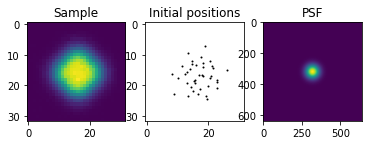

In [17]:
fig, axes = plt.subplots(ncols=3)
axes[0].imshow(sample);
axes[0].set_title(f"Sample");

axes[1].plot(initial_positions[:, 0], initial_positions[:, 1], "ok", markersize=1)
axes[1].set_title(f"Initial positions")
axes[1].set_aspect(1)
axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_ylim(axes[0].get_ylim())

axes[2].imshow(psf);
axes[2].set_title(f"PSF");

## Configure gSUPPOSe

We will initialize a GSUPPOSE object and prepare it for our run. First we tell gSUPPOSe to take our `sample`, `psf` and `initial_positions` loaded before. With the arguments `sample_pixel_size` and `psf_pixel_size` we tell the algorithm that this PSF image has a 10 times smaller grid, which is useful to reduce interpolation error. We set the argument `normalize_input` to `'std'` to normalize our sample by dividing by its standard deviation, which is useful for mantaining the same optimizer configuration (such as the learning rate) for images with different intensities.

The argument `optimizer` sets the gradient descent method that we will use, while `fitness_function` and `dfitness_function` sets the loss function that is minimized and its derivative. In this case we will us an ADAM optimizer with a Mean Squared Error loss and a `batch_size` of 5 virtual sources. The argument `global_scale` sets the learning rate and may be adjusted for each run.

Finally, the argument `device` sets the device (or a list of devices) to use for computation. Positive integers `0, 1, ...` correspond to the available GPUs while `-1` correspond to CPU. Currently, gSUPPOSe allows to distribute the computation up to 3 devices, but since our GPU implementation is much faster than CPU, we recommend to use GPU devices if possible.

In [28]:
suppose = GSUPPOSe(sample=sample,
                   psf=psf,
                   initial_positions=initial_positions,
                   sample_pixel_size=(1.0, 1.0),
                   psf_pixel_size=(.1, .1),
                   normalize_input='std',
                   optimizer='adam',
                   fitness_function=mse,
                   dfitness_function=dmse,
                   batch_size=5,
                   global_scale=1e-1,
                   device_index=0 if get_available_devices() else -1)

## Run gSUPPOSe

Now we perform our run. We will run the algorithm through a maximum of 1000 `epochs` (iterations). The argument `stop_method` adds an extra stop condition which, in this case, finishes the execution when the maximum displacement of all virtual sources in an epoch is less than `stop_limit`. The argument `report_every` tells the algorithm to print its status during the run for every `100` epochs. We also enable live plots that shows the execution (plotting do not affect computation time since it runs in a parallel process) and we save our results in a file called `basic_run.npz`.

At the current version, controlling the verbosity and the output stream is still pending.

In [29]:
suppose.run(epochs=5000,
            stop_method='max_displacement',
            stop_limit=1e-3,
            report_every=500,
            plot=False,
            save_path="basic_run.npz")

SGD-SUPPOSe started at 15/102021 16:18:35:
    Epochs: 5000
    Batch size: 5
    Image shape: (32, 32)
    PSF shape: (640, 640)
    Devices: None


Epoch 0
    Fitness: 5.64e-05 +- 0.00e+00
    Elapsed time: 0.0 s
    Mean iter time: 5.60e-03 s
      ├ Prepare batches: 4.15e-05 s (0.74 %)
      ├ Convolve batches: 1.24e-03 s (22.20 %)
      ├ Compute gradient: 7.43e-04 s (13.26 %)
      ├ Update positions: 8.66e-04 s (15.46 %)
      ├ Convolve solution: 1.92e-03 s (34.26 %)
      ├ Fit parameters: 2.54e-04 s (4.54 %)
      ├ Compute fitness: 4.74e-04 s (8.47 %)
      ├ Update plot: 0.00e+00 s (0.00 %)
      ├ Callbacks: 9.54e-07 s (0.02 %)
      ├ Others: 5.91e-05 s (1.06 %)

Epoch 500
    Fitness: 5.32e-07 +- 0.00e+00
    Elapsed time: 2.1 s
    Mean iter time: 4.24e-03 s
      ├ Prepare batches: 1.43e-05 s (0.34 %)
      ├ Convolve batches: 6.88e-04 s (16.22 %)
      ├ Compute gradient: 5.77e-04 s (13.62 %)
      ├ Update positions: 7.34e-04 s (17.31 %)
      ├ Convolve solution: 1

## Plot the results

Finally we plot the results of our run. The source intensity `alpha` can also be retrieved.

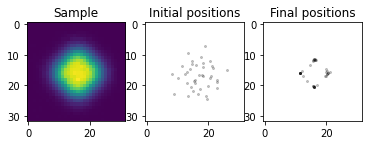

The fitted source intensity (alpha) is '2.599e-01'


In [36]:
fig, axes = plt.subplots(ncols=3)
axes[0].imshow(sample);
axes[0].set_title(f"Sample");

axes[1].plot(initial_positions[:, 0], initial_positions[:, 1], "ok", markersize=2, alpha=.2)
axes[1].set_title(f"Initial positions")
axes[1].set_aspect(1)
axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_ylim(axes[0].get_ylim())

axes[2].plot(suppose.positions[:, 0], suppose.positions[:, 1], "ok", markersize=2, alpha=.2)
axes[2].set_title(f"Final positions")
axes[2].set_aspect(1)
axes[2].set_xlim(axes[0].get_xlim())
axes[2].set_ylim(axes[0].get_ylim())

plt.show()

print(f"The fitted source intensity (alpha) is '{suppose.alpha:.3e}'")